# Analyzing Artwork
## an intro to Spark, with the help of scikit-learn + word2vec + seaborn

**Jeremy**: In this tutorial we're going to use a public data set to introduce the distributed analytics library Spark, and show how it can be integrated into a Python workflow, alongside Python libaries like scikit-learn and seaborn.

**Matt**: The data set is a collection of records from the MOMA collection that was just recently open sourced (githhub [repo](https://github.com/MuseumofModernArt/collection)). Each item is a piece of artwork in the collection, with a variety of metadata, such as the Artist, the Department, and the Medium.

**Jeremy**: We're going to perfect a sequence of analyses, starting with some basic data inspection, summarizing, and then visualizaition. Do we need Spark for these data? Definitely not! It's only about 40MB, and would be fine using local tools like `pandas`. But if the data set was significantly larger, working locally would mean each step would take much longer (several minutes, maybe even hours). Although we'll present a streamlined analyses of these data, getting there required lots of trying and testing. If every little command takes minutes or hours to execute, if can really slow us down. PySpark lets us cut that time down, while still working alongside our favorite Python tools.

## getting started

**Matt**: The first step in any data analysis workflow is loading the data, so that's where we begin! We'll load the CSV file, do some basic inspection, then grab a local sample for visualization.

First load the data.

In [228]:
df = sqlContext.read.format('com.databricks.spark.csv').options(header='true').load('../data/ArtworksScrubbed.csv')

Let's look at the basic layout of the data

In [229]:
df.show(5)

+--------------------+--------------------+---------------+----+--------------------+--------------------+
|             Artists|      Classification|CuratorApproved|Date|          Department|              Medium|
+--------------------+--------------------+---------------+----+--------------------+--------------------+
|         Otto Wagner|A&D Architectural...|              Y|1896|Architecture & De...|Ink and cut-and-p...|
|Christian de Port...|A&D Architectural...|              Y|1987|Architecture & De...|Paint and colored...|
|          Emil Hoppe|A&D Architectural...|              Y|1903|Architecture & De...|Graphite, pen, co...|
|     Bernard Tschumi|A&D Architectural...|              Y|1980|Architecture & De...|Photographic repr...|
|          Emil Hoppe|A&D Architectural...|              Y|1903|Architecture & De...|Graphite, color p...|
+--------------------+--------------------+---------------+----+--------------------+--------------------+



**Jeremy**: Let's look at the different Departments. We just need to group by the `Department` column, then `count`, then `sort`.

In [230]:
df.groupBy('Department').count().sort('count', ascending=False).show()

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|Prints & Illustra...|57935|
|         Photography|27829|
|Architecture & De...|15745|
|            Drawings|10265|
|Painting & Sculpture| 3716|
|                Film| 2579|
|   Fluxus Collection| 2544|
|Media and Perform...| 2329|
|                null|  374|
|Architecture & De...|   18|
| and pencil on paper|    5|
|              crayon|    1|
| and felt-tip pen...|    1|
| and white tin ca...|    1|
+--------------------+-----+



Most of this looks reasonable, but the last few look weird. Some of them seem to start with spaces, maybe a glitch in the file. We also want to get rid of any nulls (there are 374). We can get rid of the erroneous rows using a `filter`, and drop the nulls with `dropna`.

In [231]:
filt = df.filter(~(df['Department'].startswith(' '))).dropna()

Now let's recompute our Department counts on the filtered data

In [232]:
cats = filt.groupBy('Department').count().sort('count', ascending=False)
cats.show()

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|Prints & Illustra...|57935|
|         Photography|27829|
|Architecture & De...|15745|
|            Drawings|10265|
|Painting & Sculpture| 3716|
|                Film| 2579|
|   Fluxus Collection| 2544|
|Media and Perform...| 2329|
|Architecture & De...|   18|
+--------------------+-----+



## making a chart

**Matt**: That's better, let's turn it into a chart! It's easy to convert a `Spark` DataFrame into `Pandas` , which can be better for local inspection and visualization.

In [233]:
local = cats.toPandas()

Setup our plotting using the `seaborn` library

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

And plot the number of items in each category

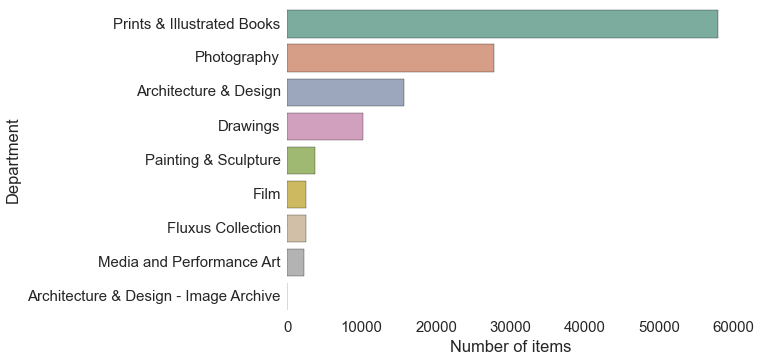

In [235]:
sns.set_context('notebook', font_scale=1.5)
pal = sns.color_palette("Set2", 9, desat=0.7)
sns.barplot(x='count', y='Department', data=local, palette=pal)
plt.xlabel('Number of items');

## words to vectors

**Jeremy**: We're interested in the relationship between the medium used for the art, and what department it's in. This will be tricky to investigate because the "medium" for each artwork is a collection of several words.

In [236]:
filt.select('Medium').show()

+--------------------+
|              Medium|
+--------------------+
|Ink and cut-and-p...|
|Paint and colored...|
|Graphite, pen, co...|
|Photographic repr...|
|Graphite, color p...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
|Gelatin silver ph...|
+--------------------+



It'd be nice if we could somehow turn these words into numbers, because that would make it easier to visualize (and to compare across the departments). A well known algorithm called `word2vec` let's us turn words into numbers (at least, that's more of less the idea, you can read more about it [here](https://code.google.com/p/word2vec/)).

Our strategy here will show how easy it is to integrate Spark with other tools in the Python data analysis stack. First, we'll use a Python package [`word2vec`](https://github.com/danielfrg/word2vec), which interfaces to the original C code developed at Google, to load an exsiting model that we trained earlier (training takes awhile so we're not doing it here). 

We'll then use a parallel Spark operation to **apply** this model to the data.

First, load the model. This was pretrained using a word dump from wikipedia (see this [notebook]() for how the training was done).

In [11]:
import word2vec

In [12]:
model = word2vec.load('../data/text8model.bin')

To see what the model can do, let's find words that are most similar to `red`. They should all be colors!

In [238]:
indexes = model.cosine('red')[0]
model.vocab[indexes].astype(str).tolist()

['blue',
 'yellow',
 'purple',
 'orange',
 'green',
 'white',
 'black',
 'pink',
 'grey',
 'colored']

Now we want to **apply** this model to the data. Spark makes it really easy to take an artibrary function in Python and apply it to each element of a large data set. First, we'll turn our `DataFrame` into an `RDD`, extracting just the two columns we care about (`Department` and `Medium`). The `RDD` is Spark's more primitive data structure (essentially a distributed collection), and will give us more flexibility in the functions we apply. We `cache` and `count` it so we don't have to recompute any of the operations up to this point.

In [239]:
rdd = filt.select(['Department', 'Medium']).rdd
rdd.cache()
rdd.count();

Now we can write a pure Python function that takes each line and returns the vector version. We need to do some icky data munging to turn the unicode strings into ascii without errors. And we also need to deal with the fact that the medium for each artwork is many words, rather than just one. One approach is to just take the mean, which is reasonable under the assumption that we are working in a vector space, which is the entire point of `word2vec`!). 

In [241]:
import numpy as np
import unicodedata

In [242]:
def vectorize(line):
    line = unicodedata.normalize('NFKD', line).encode('ascii', 'ignore')
    init = np.zeros(100)
    count = 0
    if line is None:
        return init
    else:
        for word in line.split(' '):
            try:
                vec = model[word]
                init += vec
                count += 1
            except:
                pass
        if count > 0:
            return init / count
        else:
            return init

We apply our function to each row through the `map` operation, and turn each record into a (key, value) pair where the key is the department (a string) and the value is the vectorized medium (a value)

In [243]:
processed = rdd.map(lambda line: (str(line.Department), vectorize(line.Medium)))

## bringing it together

**Matt**: At this point you could do further, parallelized processing of the results. We'll just do something simple -- remove records where the result was all 0s -- and then sample a subset for visualization.

In [244]:
local = processed.filter(lambda x: not all(x[1] == np.zeros(100))).takeSample(False, 3000)

Our local sample has both the departments and the word vectors, so let's split them apart

In [245]:
depts, vectors = zip(*local)

Let's visualize the result! We have a high-dimensional vector for each piece of artwork, and we want to visualize it in a low dimensional space. A great approach is t-SNE ([link](https://beta.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm) to O'Reilly tutorial). We'll do preprocessing first with PCA.

In [246]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [247]:
pca = PCA(n_components=20).fit_transform(np.asarray(vectors))
lowd = TSNE(n_components=2).fit_transform(pca)

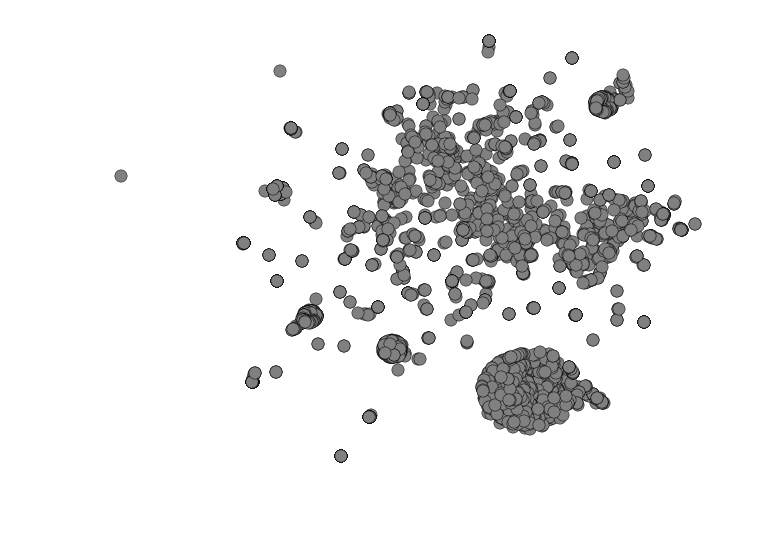

In [248]:
sns.set_context("poster")
plt.scatter(lowd[:,0], lowd[:,1], s=150, c='gray');
plt.axis('off');

Each point here is a piece of artwork, and the distances between them capture similarity in their medium. We would expect there to be some relationship between the medium used and the department the art ends up in. To look for that, we can color the plot by the department.

TODO: replace with interactive version using Lightning

In [249]:
uniq = list(set(depts))
labels = [uniq.index(item) for item in depts]
colors = [pal[l] for l in labels]

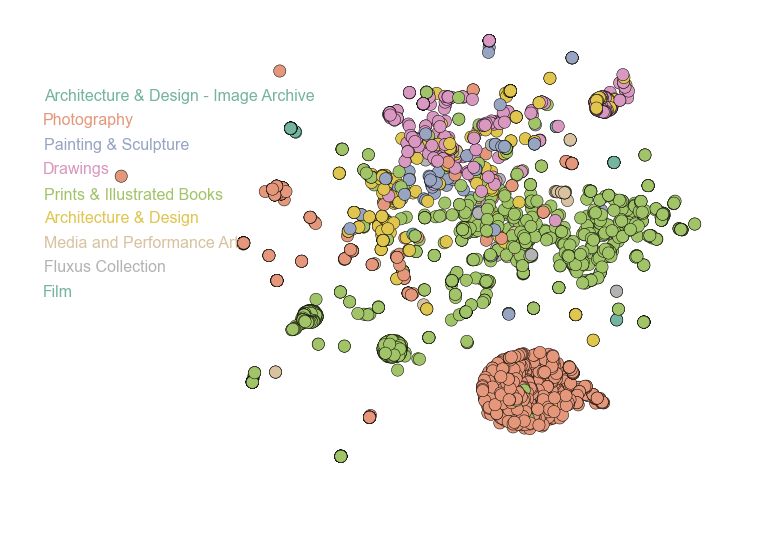

In [250]:
sns.set_context("poster")
plt.scatter(lowd[:,0], lowd[:,1], s=150, c=colors, cmap='hsv')
plt.axis('off')
for i, label in enumerate(uniq):
    plt.text(-30, 13 - i*2, label, fontsize=16, fontdict=dict(color=pal[i]))